In [30]:
# !pip install shap
!pip install dask

Defaulting to user installation because normal site-packages is not writeable


In [77]:
# Import libraries
import os
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import random
import lime
from lime import lime_tabular
import shap

import json
from typing import Union
from datetime import datetime as dt
import numpy as np


In [78]:
from dask.distributed import Client

client = Client( dashboard_address=':8087')
client


2023-09-06 11:35:55,773 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-d9a372lf', purging


<Client: 'tcp://127.0.0.1:40227' processes=8 threads=32, memory=31.10 GiB>

In [79]:
import dask.dataframe as dd

In [80]:
PROCESSED_DATA = "/storage/scratch/e17-4yp-xai/Documents/e17-4yp-using-machine-learning-in-high-stake-settings/code/processed_data/processed_final_data.csv"
SAMPLE_ID =  "/storage/scratch/e17-4yp-xai/Documents/e17-4yp-using-machine-learning-in-high-stake-settings/code/model_outputs/artifacts/sampled_data_project_ids.csv"

In [81]:
raw_data = dd.read_csv(PROCESSED_DATA)
sampled_raw_data = pd.read_csv(SAMPLE_ID)

In [82]:
#RuntimeError: No visualization engine detected, please install graphviz or ipycytoscape
# !pip uninstall graphviz -y

In [83]:
# Dask constructs logic called task graph of your computationimmediately them only when necessary. this graph can be visualized as below
raw_data.visualize()

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [84]:
sampled_raw_data.tail()

Unnamed: 0                        Project ID  Label
299995      197738  a426a554b5e622e9185ab51bc6a1903a      0
299996      435220  bd54c6e48251e0fc6671fdd9689255ed      0
299997      429243  9ef96ca72d6090d829e855b6b1a7c7b3      0
299998      330275  37830394c65ca2fbbd6dddcded40e16a      0
299999      143577  769bbc2927b613c9d4facc0ba53eae6a      0

In [85]:
filtered_data = raw_data[raw_data["Project ID"].isin(sampled_raw_data["Project ID"])]

In [86]:
filtered_data.shape

(Delayed('int-4ecd93a0-f3e6-4862-9ae2-dc2e419f2db9'), 28)

In [87]:
filtered_data.head()

Unnamed: 0                        Project ID Project Posted Date  \
0           0  fc71f1392dc1804262ca29696d5a1c6c          2014-01-03   
1           1  7bb325d4691141fc001854e87e6506db          2016-09-08   
3           5  b200ed5bf0d9e113d3d50c26e3b98bc5          2016-11-26   
4           6  325a84427633fac794bca9ae7d3915f6          2015-02-24   
6           8  909083bd12a631a76cf828ac454cf0a0          2015-08-21   

  Project Type        Project Subject Category Tree  Project Cost  \
0  Teacher-Led  Math & Science, Literacy & Language        326.12   
1  Teacher-Led                       Math & Science        297.95   
3  Teacher-Led                  Literacy & Language        305.26   
4  Teacher-Led                     Applied Learning        487.86   
6  Teacher-Led                  Literacy & Language        295.45   

  Project Subject Subcategory Tree Project Grade Level Category  \
0  Environmental Science, Literacy                  Grades 9-12   
1    Applied Sciences, Mathematics                Grades PreK-2   
3   Literacy, Literature & Writing                Grades PreK-2   
4               Parent Involvement                Grades PreK-2   
6                    ESL, Literacy                  Grades 9-12   

  Project Resource Category School Metro Type  ...  Label  \
0                     Books             urban  ...      0   
1                  Supplies             urban  ...      0   
3                     Books             rural  ...      0   
4                  Supplies          suburban  ...      0   
6                Technology          suburban  ...      0   

  Teacher Success Rate Teacher Success Rate Imputed School City Success Rate  \
0                  0.0                            1                 0.000000   
1                  0.0                            1                 0.803030   
3                  0.0                            1                 0.714286   
4                  1.0                            0                 1.000000   
6                  0.0                            1                 0.800000   

  School City Success Rate Imputed School Success Rate  \
0                                1            0.000000   
1                                0            0.666667   
3                                0            1.000000   
4                                0            1.000000   
6                                0            0.000000   

  School Success Rate Imputed  School County Success Rate  \
0                           1                    0.000000   
1                           0                    0.790951   
3                           0                    1.000000   
4                           0                    0.688679   
6                           1                    0.763473   

   School County Success Rate Imputed  Project Count in State  
0                                   1                       0  
1                                   0                    2851  
3                                   0                    1051  
4                                   0                    2093  
6                                   0                    1244  

[5 rows x 28 columns]

In [88]:

# os.chdir("code")
import os
import feature_engineer as fe 
import data_processor as dp
import config
from helper import (
    save_model,
    load_model,
    create_dirs,
    create_classification_models,
    create_logistic_regression_parameters,
    create_random_forest_parameters,
    create_xgb_classifier_parameters,
    log_intermediate_output_to_file,
    filter_dataset_by_date)
import temporal_features as tmpf
import config

In [90]:
print("Loading already processed data")
# data = dp.load_data_to_df(path=data_file_path)
data = dp.set_data_types_to_datetime(filtered_data.compute(), ["Project Posted Date"])
data = filter_dataset_by_date(data)

print("After adding new Features, shape = ", data.shape)
print(data.columns)

data_1 = dp.encode_data(data, config.CATEGORICAL_COLS)

print("encoded_data.shape = ", data_1.shape)

# data_folds = fe.split_data_folds(data_1)


Loading already processed data
After adding new Features, shape =  (300000, 28)
Index(['Unnamed: 0', 'Project ID', 'Project Posted Date', 'Project Type',
       'Project Subject Category Tree', 'Project Cost',
       'Project Subject Subcategory Tree', 'Project Grade Level Category',
       'Project Resource Category', 'School Metro Type',
       'School Percentage Free Lunch', 'School State', 'School County',
       'School Name', 'School City', 'School District', 'Teacher Prefix',
       'Teacher Project Posted Sequence', 'Label', 'Teacher Success Rate',
       'Teacher Success Rate Imputed', 'School City Success Rate',
       'School City Success Rate Imputed', 'School Success Rate',
       'School Success Rate Imputed', 'School County Success Rate',
       'School County Success Rate Imputed', 'Project Count in State'],
      dtype='object')


2023-09-06 11:44:59,861 - bokeh.core.property.validation - ERROR - 'start'
Traceback (most recent call last):
  File "/storage/scratch/e17-4yp-xai/anaconda/lib/python3.10/site-packages/distributed/utils.py", line 784, in wrapper
    return func(*args, **kwargs)
  File "/storage/scratch/e17-4yp-xai/anaconda/lib/python3.10/site-packages/distributed/dashboard/components/shared.py", line 295, in update
    ts = metadata["keys"][self.key]
KeyError: 'start'
2023-09-06 11:45:00,053 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7ff2299c0d30>>, <Task finished name='Task-533606' coro=<ServerSession.with_document_locked() done, defined at /storage/scratch/e17-4yp-xai/anaconda/lib/python3.10/site-packages/bokeh/server/session.py:78> exception=KeyError('start')>)
Traceback (most recent call last):
  File "/storage/scratch/e17-4yp-xai/anaconda/lib/python3.10/site-packages/tornado/iolo

encoded_data.shape =  (300000, 60077)


In [ ]:
data_folds = fe.split_data_folds(data_1)

-----
train    2016-01-07 - 2016-07-05
test     2016-11-02 - 2016-12-02


2023-09-06 12:25:40,990 - bokeh.core.property.validation - ERROR - 'start'
Traceback (most recent call last):
  File "/storage/scratch/e17-4yp-xai/anaconda/lib/python3.10/site-packages/distributed/utils.py", line 784, in wrapper
    return func(*args, **kwargs)
  File "/storage/scratch/e17-4yp-xai/anaconda/lib/python3.10/site-packages/distributed/dashboard/components/shared.py", line 295, in update
    ts = metadata["keys"][self.key]
KeyError: 'start'
2023-09-06 12:25:41,058 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7ff2299c0d30>>, <Task finished name='Task-1051413' coro=<ServerSession.with_document_locked() done, defined at /storage/scratch/e17-4yp-xai/anaconda/lib/python3.10/site-packages/bokeh/server/session.py:78> exception=KeyError('start')>)
Traceback (most recent call last):
  File "/storage/scratch/e17-4yp-xai/anaconda/lib/python3.10/site-packages/tornado/iol

Define the necessary paths to obtain data sources after running the main pipeline

In [134]:
root_test = "/storage/scratch/e17-4yp-xai/Documents/e17-4yp-using-machine-learning-in-high-stake-settings/code/model_outputs/artifacts/random_forest_t_200_md_4"

In [135]:
root_train = "/storage/scratch/e17-4yp-xai/cepdnaclk/e17-4yp-using-machine-learning-in-high-stake-settings/code/model_outputs/info"

In [136]:
train_files = sorted(['Fold 1 - 2016-01-07.json', 'Fold 4 - 2015-01-12.json',
'Fold 2 - 2015-09-09.json', 'Fold 5 - 2014-09-14.json',
'Fold 3 - 2015-05-12.json',  'Fold 6 - 2014-05-17.json'], reverse=True)

In [137]:
test_files = sorted(["test_prediction_fold_1_2016-01-07.csv",  "test_prediction_fold_4_2015-01-12.csv",
"test_prediction_fold_2_2015-09-09.csv",  "test_prediction_fold_5_2014-09-14.csv",
"test_prediction_fold_3_2015-05-12.csv",  "test_prediction_fold_6_2014-05-17.csv"], reverse=True)

In [139]:
models = sorted(["random_forest_t_200_md_4_fold_1_2016-01-07.pkl",
"random_forest_t_200_md_4_fold_2_2015-09-09.pkl",
"random_forest_t_200_md_4_fold_3_2015-05-12.pkl",
"random_forest_t_200_md_4_fold_4_2015-01-12.pkl",
"random_forest_t_200_md_4_fold_5_2014-09-14.pkl",
"random_forest_t_200_md_4_fold_6_2014-05-17.pkl"], reverse=True)

In [3]:
train_files = sorted(['train_fold_1_2017-01-06.csv', 'train_fold_2_2016-09-08.csv', 'train_fold_3_2016-05-11.csv', 'train_fold_4_2016-01-12.csv', 'train_fold_5_2015-09-14.csv' , 'train_fold_6_2015-05-17.csv'], reverse=True)
test_files = [ 'test_fold_6_2015-05-17.csv' , 'test_fold_5_2015-09-14.csv', 'test_fold_4_2016-01-12.csv', 'test_fold_3_2016-05-11.csv',  'test_fold_2_2016-09-08.csv', 'test_fold_1_2017-01-06.csv']


test_pred = ['test_prediction_fold_6_2015-05-17.csv' , 'test_prediction_fold_5_2015-09-14.csv', 'test_prediction_fold_4_2016-01-12.csv', 'test_prediction_fold_3_2016-05-11.csv', 'test_prediction_fold_2_2016-09-08.csv' , 'test_prediction_fold_1_2017-01-06.csv' ]

models = sorted(["random_forest_fold_1_2017-01-06.pkl", "random_forest_fold_2_2016-09-08.pkl", "random_forest_fold_3_2016-05-11.pkl", "random_forest_fold_4_2016-01-12.pkl", "random_forest_fold_5_2015-09-14.pkl", "random_forest_fold_6_2015-05-17.pkl" ], reverse = True)

In [4]:
#### SET PATH
# ROOT = "/storage/scratch/e17-4yp-xai/Documents/e17-4yp-using-machine-learning-in-high-stake-settings/code/"
ROOT = "./"
LIME_DEST = ROOT + "model_outputs/lime/"
SHAP_DEST = ROOT + "model_outputs/shap/"
TREESHAP_DEST = ROOT + "model_outputs/treeshap/"


In [2]:
# Define paths for testing locally  - comment out when not required 
root = 'C:/Users/User/random_forest/'
train_files = sorted(['train_fold_1_2017-01-06.csv'])
test_files = ['test_fold_1_2017-01-06.csv']
test_pred = ['test_prediction_fold_1_2017-01-06.csv']
models = sorted(["random_forest_fold_1_2017-01-06.pkl"])
LIME_DEST = root + "xai_test_results/lime/"
SHAP_DEST = root + "xai_test_results/kernelshap/"
TREESHAP_DEST = root + "xai_test_results/treeshap/"
OUTPUT_DEST = root + "xai_test_results/"

In [3]:
# Required helper functions

def load_model(model_file_path):
    return pickle.load(open(model_file_path, 'rb'))

def save_json(dict_obj: Union[dict, list], path: str):
    writable_json = json.dumps(dict_obj, indent=4)
    with open(path, 'w') as file:
        file.write(writable_json)

Functions for LIME, TreeSHAP and KernelSHAP

In [4]:

# Functions used to generate LIME explanation and to save the explanation

# Function to convert the features in a LIME explanation object to a list of tuples
def get_lime_feature_list(exp_object, feat_names):
    exp_list = exp_object.as_map().get(1)
    exp_list_with_feature_names = [(feat_names[x[0]], x[1]) for x in exp_list]
    print(f'exp_list_with_feature_names = {exp_list_with_feature_names}')
    return exp_list_with_feature_names

def get_lime_feature_list_encoded(exp_object):
    exp_list = exp_object.as_map().get(1)
    print(f'exp_list = {exp_list}')
    return exp_list

def save_lime_explanation(exp, instance_loc, model_name, position, project_id,fold):

    # exp.show_in_notebook(show_table=True)
    # Save as html file
    filepath = f"{LIME_DEST}{fold}/{position}"
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")

    # Saving the explanation as an image
    exp.save_to_file(f'{LIME_DEST}{fold}/{position}/lime_exp_{project_id}_{model_name}.html')

    # Save as pyplot figure
    exp.as_pyplot_figure()
    plt.savefig(f'{LIME_DEST}{fold}/{position}/lime_exp_{project_id}_{model_name}.png')
    print(f"Saving lime exp for {project_id}_{model_name}")
    plt.show()
    plt.cla()

    return


# Function to generate explanations for a list of instances
def get_lime_for_list(instance_loc_list, x_test, explainer_lime, model, model_name, list_type, fold, num_of_feat):

    # Dictionary used to save the explanation objects
    exp_objects = {}
    exp_as_list_objects = {}
    
    for instance_loc in instance_loc_list:
        # Select instance
        instance = x_test.iloc[instance_loc]
        # Find its Project ID
        project_id = instance["Project ID"]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"])
        # Get the explanation
        exp = explainer_lime.explain_instance(
            data_row=instance,
            predict_fn=model.predict_proba,
            num_features=num_of_feat
        )
        # Append exp object to dictionary
        exp_objects[project_id] = exp
        # Find the feature names as a list
        feat_names = instance.keys().to_list()
        # Get the explanation as a list of tuples and save
        exp_as_list = get_lime_feature_list(exp, feat_names)
        exp_as_list_objects[project_id] = exp_as_list
        # Save the explanation as a figure
        save_lime_explanation(exp, instance_loc, model_name, list_type, project_id, fold)
        
    return exp_objects, exp_as_list_objects

def get_lime_explanation(x_train, x_test, top_instance_loc_list, bottom_instance_loc_list, class_names, mode, model, model_name, fold, num_of_feat):

    # take the list of instances and save the explaination of each instance.
    # LIME: define the explainer
    # Ex: mode = 'classification' or 'regression'
    #     class_names = ['0', '1']

    categorical_feature_names = x_train.dtypes[x_train.dtypes==bool].index.to_list()
    categorical_feature_index = [x_train.columns.get_loc(col) for col in categorical_feature_names]
    
    # Define the explainer
    explainer_lime = lime_tabular.LimeTabularExplainer(
        training_data=np.array(x_train),
        feature_names=x_train.columns,
        categorical_features = categorical_feature_index,
        class_names=class_names,
        mode=mode
    )
    
    # Get LIME explanations for both top and bottom lists with Project ID
    print("Top list")
    exp_objects_top, exp_as_list_objects_top = get_lime_for_list(top_instance_loc_list, x_test, explainer_lime, model, model_name, "top", fold, num_of_feat)
    print("Bottom list")
    exp_objects_bottom, exp_as_list_objects_bottom = get_lime_for_list(bottom_instance_loc_list, x_test, explainer_lime, model, model_name, "bottom", fold, num_of_feat)
    
    return exp_as_list_objects_top, exp_as_list_objects_bottom




In [5]:
def save_treeshap_explanation(explainer_tree, exp, instance, model_name, list_type, project_id, fold):

    # Visualize and save
    filepath = f'{TREESHAP_DEST}{fold}/{list_type}/treeshap_exp_{project_id}_{model_name}.png'
    print(f"Saving treeshap exp for {filepath}")
    shap.force_plot(explainer_tree.expected_value[1], 
                exp[1],
                instance,
                show=False, 
                matplotlib=True, 
                text_rotation=45).savefig(filepath, format = "png", dpi = 150, bbox_inches = 'tight')
    return


def get_treeshap_feature_list(exp, feat_names, num_of_feat):
    
    # Create list of tuples
    shap_values = dict(zip(feat_names, exp[1][0]))
    sorted_shap_exp = sorted(shap_values.items(), key=lambda x:abs(x[1]), reverse=True)[:num_of_feat]

    #exp_list = exp[1].tolist()
    #exp_list_with_feature_names = [(feat_names[x], exp_list[x]) for x in range(len(exp_list))]
    #print(f'exp_list_with_feature_names = {exp_list_with_feature_names}')
    
    return sorted_shap_exp


# Function to generate explanations for a list of instances
def get_treeshap_for_list(instance_loc_list, x_test, explainer_tree, model_name, list_type, fold, num_of_feat):

    # Dictionary used to save the explanation objects
    exp_objects = {}
    exp_as_list_objects = {}
    
    for i, instance_loc in enumerate(instance_loc_list):
        # Select instance
        instance = x_test.iloc[[instance_loc]]
        # Find its Project ID
        project_id = instance["Project ID"].values[0]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"], axis=1)
        # Get the explanation
        exp = explainer_tree.shap_values(instance)
        #print(f'exp[1] = {exp[1]}')
        # Append exp object to dictionary
        exp_objects[project_id] = exp
        # Find the feature names as a list
        feat_names = instance.columns.to_list()
        print(f'len(exp[1][0]) = {len(exp[1][0])}')
        print(f'len(feat_names) = {len(feat_names)}')
        print(f'exp[1][0] = {exp[1][0]}')
        print(f'feat_names top {num_of_feat} = {feat_names[:num_of_feat]}')
        
        # Get the explanation as a list of tuples and save
        exp_as_list = get_treeshap_feature_list(exp, feat_names, num_of_feat)
        exp_as_list_objects[project_id] = exp_as_list
        #print(exp_as_list)
        print(f'type(exp_as_list) = {type(exp_as_list)}')
        # Save the explanation as a figure
        save_treeshap_explanation(explainer_tree, exp, instance, model_name, list_type, project_id, fold)
        
    return exp_objects, exp_as_list_objects


def get_treeshap_explanation(x_train, x_test, top_instance_loc_list, bottom_instance_loc_list, model, model_name, fold, num_of_feat):
    
#     print(x_train.head())
    # Define the KernelSHAP explainer
#     explainer_tree = shap.TreeExplainer(model=model, data=x_train, model_output="raw")
    print(f"Treeshap explainer: Start training")
    explainer_tree = shap.TreeExplainer(model=model, feature_perturbation='interventional', data=x_train, model_output="raw")
    print(f"Treeshap explainer: Done training")
    
    filepath = f'{TREESHAP_DEST}{fold}/top/'
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
        
    filepath = f'{TREESHAP_DEST}{fold}/bottom/'
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
            
    print("Top list")          
    exp_objects_top, exp_as_list_objects_top = get_treeshap_for_list(top_instance_loc_list, x_test, explainer_tree, model_name, "top", fold, num_of_feat)
    
    print("Bottom list")
    exp_objects_bottom, exp_as_list_objects_bottom = get_treeshap_for_list(bottom_instance_loc_list, x_test, explainer_tree, model_name, "bottom", fold, num_of_feat)
    
    return exp_as_list_objects_top, exp_as_list_objects_bottom



In [6]:
def save_kernelshap_explanation(explainer_tree, exp, instance, model_name, list_type, project_id, fold):

    # Visualize and save
    filepath = f'{SHAP_DEST}{fold}/{list_type}/kernelshap_exp_{project_id}_{model_name}.png'
    print(f"Saving kernelshap exp for {filepath}")
    shap.force_plot(explainer_tree.expected_value[1], 
                exp[1],
                instance,
                show=False, 
                matplotlib=True, 
                text_rotation=45).savefig(filepath, format = "png", dpi = 150, bbox_inches = 'tight')
    return

def get_kernelshap_feature_list(exp, feat_names, num_of_feat):
    
    # Create list of tuples
    shap_values = dict(zip(feat_names, exp[1]))
    sorted_shap_exp = sorted(shap_values.items(), key=lambda x:abs(x[1]), reverse=True)[:num_of_feat]

    #exp_list = exp[1].tolist()
    #exp_list_with_feature_names = [(feat_names[x], exp_list[x]) for x in range(len(exp_list))]
    #print(f'exp_list_with_feature_names = {exp_list_with_feature_names}')
    
    return sorted_shap_exp


# Function to generate explanations for a list of instances
def get_kernelshap_for_list(instance_loc_list, x_test, explainer_tree, model_name, list_type, fold, num_of_feat, nsamples):

    # Dictionary used to save the explanation objects
    exp_objects = {}
    exp_as_list_objects = {}
    
    for i, instance_loc in enumerate(instance_loc_list):
        # Select instance
        instance = x_test.iloc[instance_loc]
        # Find its Project ID
        project_id = instance["Project ID"]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"])
        
        # Get the explanation
        exp = explainer_tree.shap_values(instance, nsamples=nsamples) # nsamples can be either 'auto' or an int
        print(f'len(exp[1]) = {len(exp[1])}')
        print(f'exp[1] = {exp[1]}')
        # Find the feature names as a list
        feat_names = instance.keys().to_list()
        print(f'len(feat_names) = {len(feat_names)}')
        print(f'feat_names top entries = {feat_names[:num_of_feat]}')
        
        # Append exp object to dictionary
        exp_objects[project_id] = exp
        # Get the explanation as a list of tuples and save
        exp_as_list = get_kernelshap_feature_list(exp, feat_names, num_of_feat)
        exp_as_list_objects[project_id] = exp_as_list
        
        print(f'type(exp_as_list) = {type(exp_as_list)}')
        # Save the explanation as a figure
        save_kernelshap_explanation(explainer_tree, exp, instance, model_name, list_type, project_id, fold)
        
    return exp_objects, exp_as_list_objects



def get_kernelshap_explanation(x_train, x_test, top_instance_loc_list, bottom_instance_loc_list, model, model_name, fold, num_of_feat, nsamples):
    
    # Define the KernelSHAP explainer
    print("Kernel Explainer Loading ..... ")
    explainer_shap = shap.KernelExplainer(model=model.predict_proba, data=x_train)
    print("Kernel Explainer : Done training")
    
    filepath = f'{SHAP_DEST}{fold}/top/'
    
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
        
    filepath = f'{SHAP_DEST}{fold}/bottom/'
    
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
            
            
    print("Top list")    
    exp_objects_top, exp_as_list_objects_top = get_kernelshap_for_list(top_instance_loc_list, x_test, explainer_shap, model_name, "top", fold, num_of_feat, nsamples)   
    print("Bottom list")
    exp_objects_bottom, exp_as_list_objects_bottom = get_kernelshap_for_list(bottom_instance_loc_list, x_test, explainer_shap, model_name, "bottom", fold, num_of_feat, nsamples)

    return exp_as_list_objects_top, exp_as_list_objects_bottom

In [18]:
# Function used to create csv using explanations
def create_csv_for_exps(feat_names, lime_dict, treeshap_dict, kernelshap_dict, list_type, fold):
    # First create an empty df
    data = pd.DataFrame()
    # Create feature column
    data['features'] = feat_names
    # Create columns to store lime, treeshap and kernalshap values for each project in the dictionary
    projects_list = list(lime_dict.keys())
    print(f'Projects list = {projects_list}')
    for project in projects_list:
        # Create empty columns
        data[f'lime_{list_type}_{project}'] = "" 
        data[f'treeshap_{list_type}_{project}'] = ""
        data[f'kernelshap_{list_type}_{project}'] = ""

        # Get lime, treeshap and kernelshap lists of tuples
        lime_list = lime_dict[project]
        treeshap_list = treeshap_dict[project]
        kernelshap_list = kernelshap_dict[project]

        # Fill the necessary cells with data
        # For lime
        for item in lime_list:
            feature = item[0]
            value = item[1]
            data.loc[data['features'] == feature, f'lime_{list_type}_{project}'] = value
        # For treeshap
        for item in treeshap_list:
            feature = item[0]
            value = item[1]
            data.loc[data['features'] == feature, f'treeshap_{list_type}_{project}'] = value
        # For kernelshap
        for item in kernelshap_list:
            feature = item[0]
            value = item[1]
            data.loc[data['features'] == feature, f'kernelshap_{list_type}_{project}'] = value

    
    print(data.columns)
    # Save as csv
    data.to_csv(OUTPUT_DEST+f'all_explanations_{fold}_{list_type}.csv') #### MAKE SURE OUTPUT_DEST IS DEFINED
    
    return data

In [19]:
# New pipeline for running the explainations - call this from main
def explanations_pipeline(root, model_paths, train_paths, test_paths, pred_paths, model_name):
  """this pipeline will generate explanations for the given model paths

  Args:
      root (_type_): This is the root path of the model artifacts
      model_paths (_type_): these are the paths to the model artifacts
      train_paths (_type_): these are the paths to the train artifacts
      test_paths (_type_): these are the paths to the test artifacts
      pred_paths (_type_): these are the paths to the prediction artifacts
      model_name (str): this is the model name as a string for identification. ex: "random forest"
      
      all the artifacts should be a list of files and should be in the same order
  """
  assert len(train_paths) == len(test_paths), "There should be same number of train paths and test paths"
  assert len(test_paths) == len(pred_paths), "There should be same number of predictions paths and test paths"
  assert len(model_paths) == len(test_paths), "There should be same number of model_paths paths and test paths"

  num_of_explanations = 1 # Should be 50 #### CHANGE THE VALUE TO 50
  num_of_records = 20 # Should be 1000 #### CHANGE THE VALUE TO 1000
  rows = 1000 # Should be None #### CHANGE THE VALUE TO NONE

  # Dictionary to store all explanations
  all_exp_dict = {}

  # Loop to generate explanations for samples from each fold
  for i in range(len(train_paths)):
    print(f"Fold {i} .............................")
    x_train = pd.read_csv(os.path.join(root, train_paths[i]), nrows=rows)
    x_train_cleaned = x_train.drop(["Unnamed: 0", "Project ID", "Label"], axis=1)

    fold1 = pd.read_csv(os.path.join(root,test_paths[i]), nrows=rows)
    fold_pred =  pd.read_csv(os.path.join(root,  pred_paths[i]), nrows=rows)
    Fold1 = pd.concat([fold1, fold_pred["1"]],axis=1)
    Fold1 = Fold1.drop(["Unnamed: 0"],axis=1)
    Fold1_sort = Fold1.sort_values(["1"], ascending=False)
    #Fold1_sort.head()
    x_test_with_id = Fold1_sort.drop([ "Label", "1"],axis=1)

    # Select n samples each from top and bottom k records
    print(f"Sampling the top {num_of_explanations} and bottom {num_of_explanations}")
    top_instance_loc_list = random.sample(range(num_of_records), num_of_explanations)
    bottom_instance_loc_list = random.sample(range(x_test_with_id.shape[0]-num_of_records , x_test_with_id.shape[0]), num_of_explanations)
    print(f'top_instance_loc_list = {top_instance_loc_list}')
    print(f'bottom_instance_loc_list = {bottom_instance_loc_list}')
      
    # Define the number of features required to display after generating the explanations
    #num_of_feat = x_test_with_id.shape[1] - 1
    num_of_feat = 10 #### COMMENT THIS UNCOMMENT THE PREVIOUS LINE
    x_train_n_rows = 100 #### CHANGE IF NECESSARY

    print(f"Model {model_paths} is loading")

    # Load the saved model
    model = load_model(os.path.join(root, model_paths[i]))

    # Get explanations
    print(f"Explanation for Lime")
    lime_list_objects_top, lime_list_objects_bottom = get_lime_explanation(x_train_cleaned[:x_train_n_rows].astype("float64"), x_test_with_id, top_instance_loc_list, bottom_instance_loc_list, ["0", "1"], "classification", model, model_name, f"Fold{i}", num_of_feat)
    print(f"Explanation for Kernel Shap" )
    kernelshap_list_objects_top, kernelshap_list_objects_bottom = get_kernelshap_explanation(x_train_cleaned[:x_train_n_rows].astype("float64"), x_test_with_id, top_instance_loc_list, bottom_instance_loc_list, model, model_name, f"Fold{i}", num_of_feat, 100) 
    print(f"Explanation for Tree Shap")
    treeshap_list_objects_top, treeshap_list_objects_bottom = get_treeshap_explanation(x_train_cleaned[:x_train_n_rows].astype("float64"), x_test_with_id, top_instance_loc_list, bottom_instance_loc_list, model, model_name, f"Fold{i}", num_of_feat) 

    #print(lime_list_objects_top)
    #print(treeshap_list_objects_top)
    #print(kernelshap_list_objects_top)

    # Create dictionaries to store the explanations as json
    current_fold_dict = {
        'lime': {
            'top': lime_list_objects_top,
            'bottom': lime_list_objects_bottom
        },
        'treeshap': {
            'top': treeshap_list_objects_top,
            'bottom': treeshap_list_objects_bottom
        },
        'kernelshap': {
            'top': kernelshap_list_objects_top,
            'bottom': kernelshap_list_objects_bottom
        }
    }
    all_exp_dict[f"fold{i}"] = current_fold_dict

  # Get a list of all the features
  list_of_features = x_test_with_id.drop(["Project ID"],axis=1).columns.to_list()
  # Storing explanations as json
  save_json(all_exp_dict, OUTPUT_DEST+'all_exp.json') #### MAKE SURE OUTPUT_DEST IS DEFINED

  # Creating top and bottom csvs for each fold to summarize explanations
  for i in range(len(train_paths)):
      # For the top list
      top_df = create_csv_for_exps(list_of_features, all_exp_dict[f"fold{i}"]["lime"]["top"], all_exp_dict[f"fold{i}"]["treeshap"]["top"], all_exp_dict[f"fold{i}"]["kernelshap"]["top"], "top", f"fold{i}")
      # For the bottom list
      bottom_df = create_csv_for_exps(list_of_features, all_exp_dict[f"fold{i}"]["lime"]["bottom"], all_exp_dict[f"fold{i}"]["treeshap"]["bottom"], all_exp_dict[f"fold{i}"]["kernelshap"]["bottom"], "bottom", f"fold{i}")
    
  
  return

Fold 0 .............................
Sampling the top 1 and bottom 1
top_instance_loc_list = [8]
bottom_instance_loc_list = [980]
Model ['random_forest_fold_1_2017-01-06.pkl'] is loading
Explanation for Lime
Top list


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


exp_list_with_feature_names = [('School Name_Copper Hills High School', -0.06256868387461345), ('School District_Weber School District', -0.060424519386926036), ('School State_South Carolina', 0.053001289255789424), ('School County_Greenville', 0.053001289255789424), ('Project Resource Category_Educational Kits & Games', 0.053001289255789404), ('School Name_Chandler Creek Elementary School', 0.05300128925578939), ('School City_Greer', 0.053001289255789376), ('School District_Greenville Co School District', 0.053001289255789376), ('Project Grade Level Category_Grades 9-12', -0.043153947540936585), ('School Name_Joel P Jensen Middle School', -0.041231274027255384)]
Directory 'C:/Users/User/random_forest/xai_test_results/lime/Fold0/top' created successfully
Saving lime exp for 80ecf97d4a4e0da994e38b593318dd72_random_forest


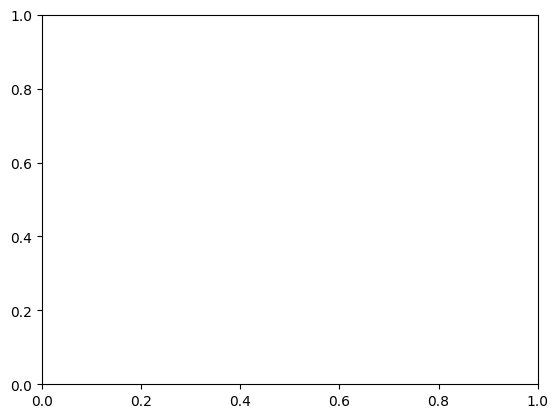

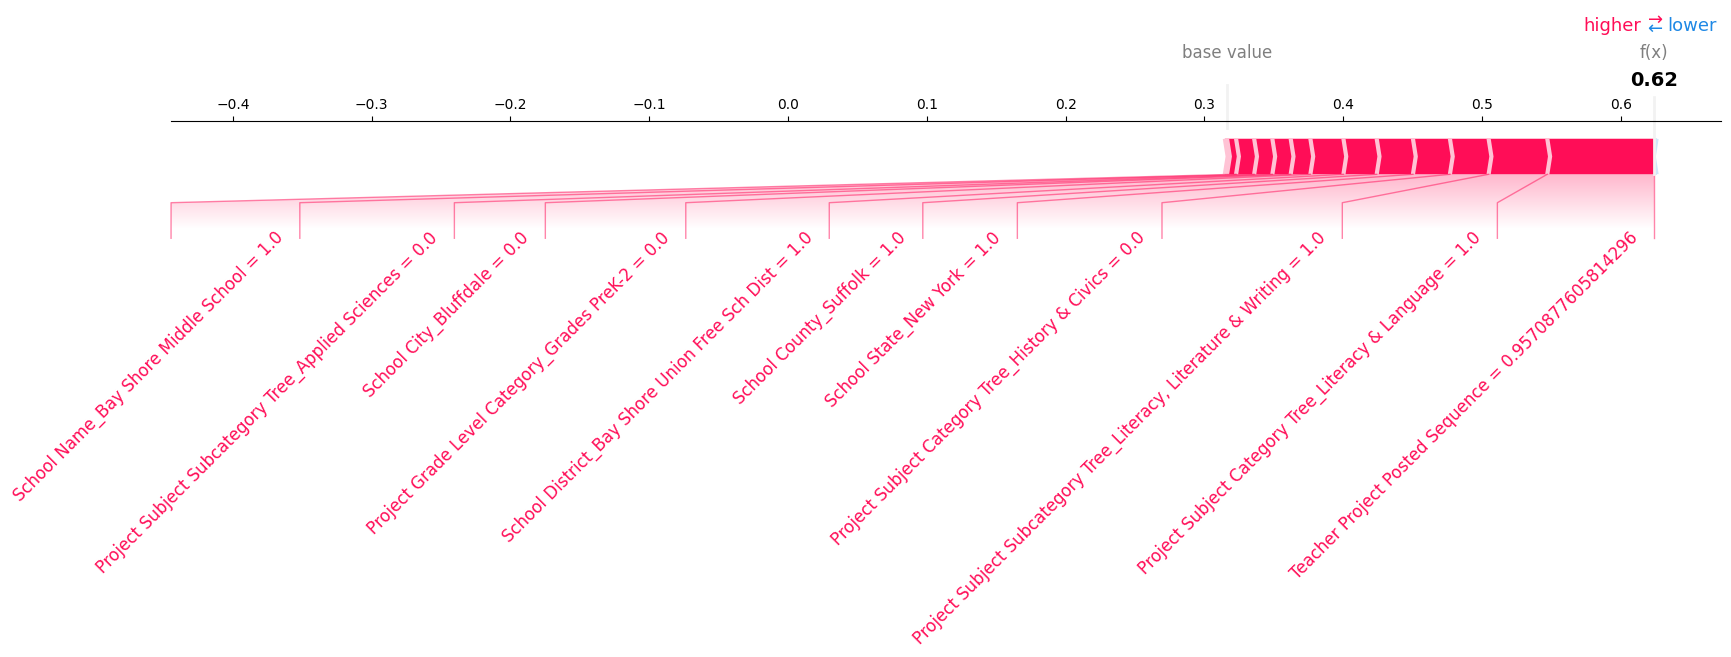

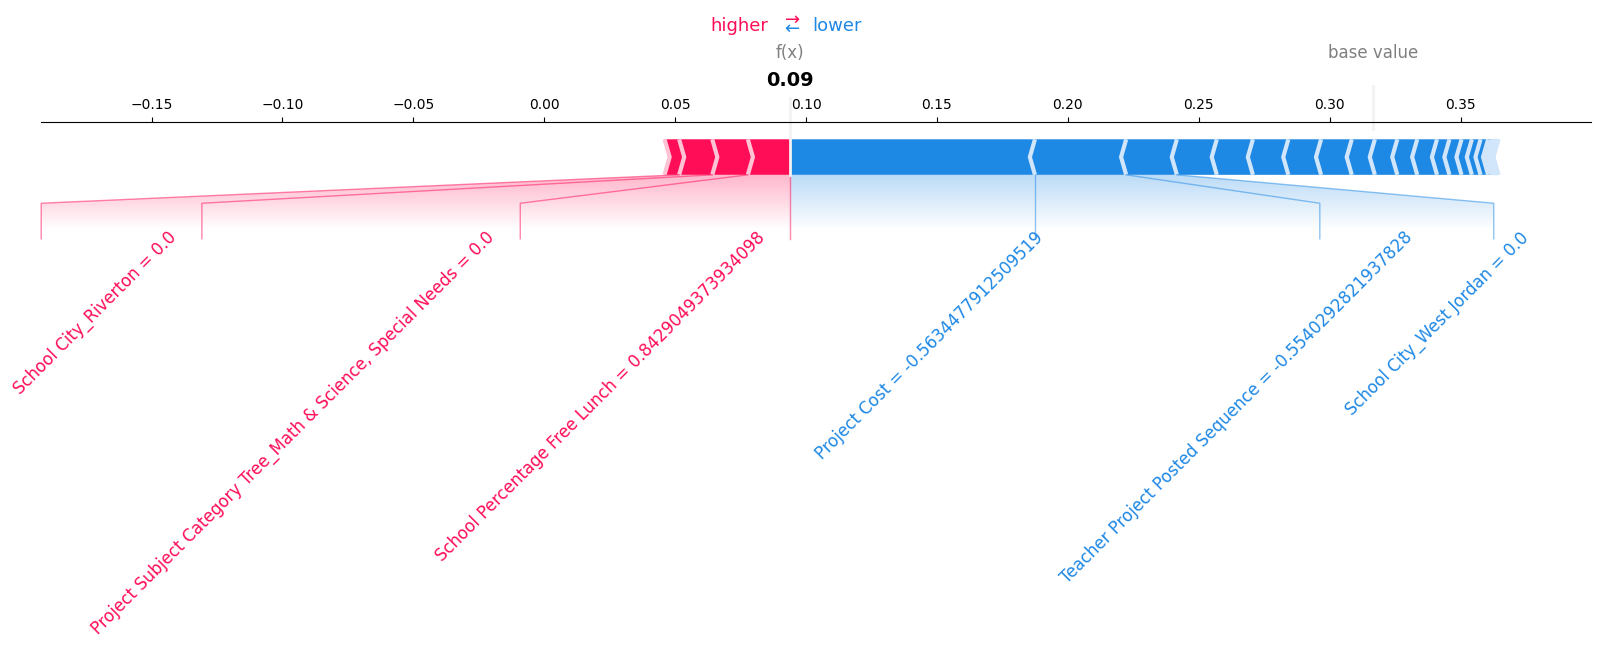

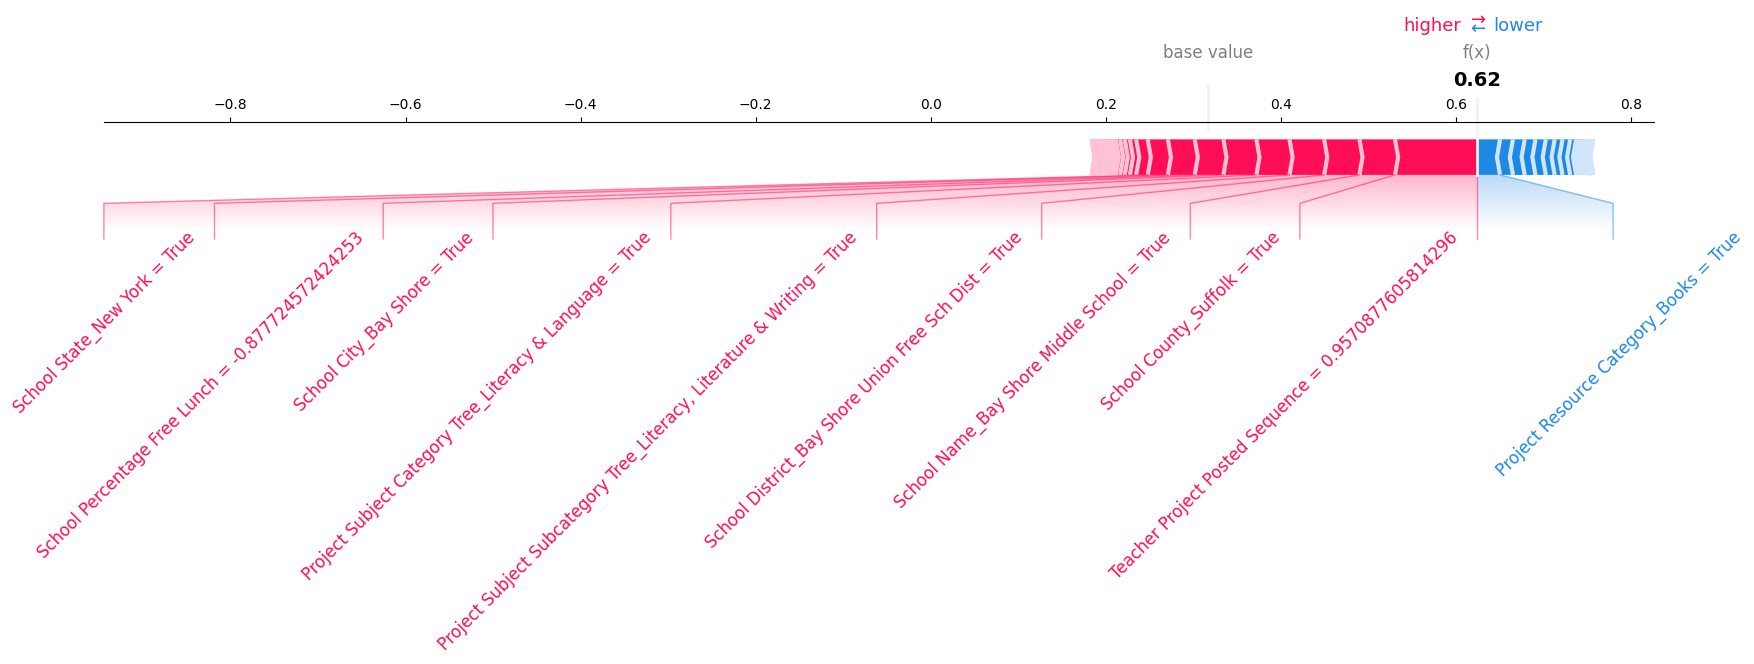

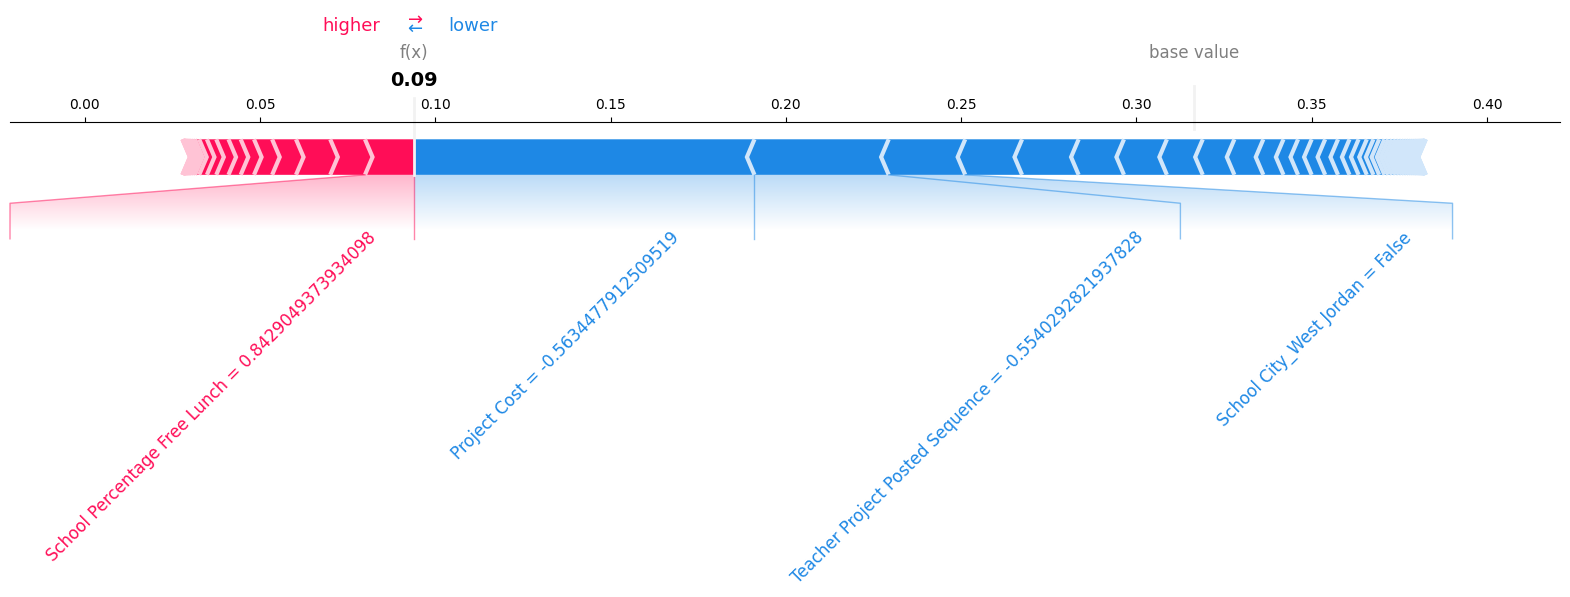

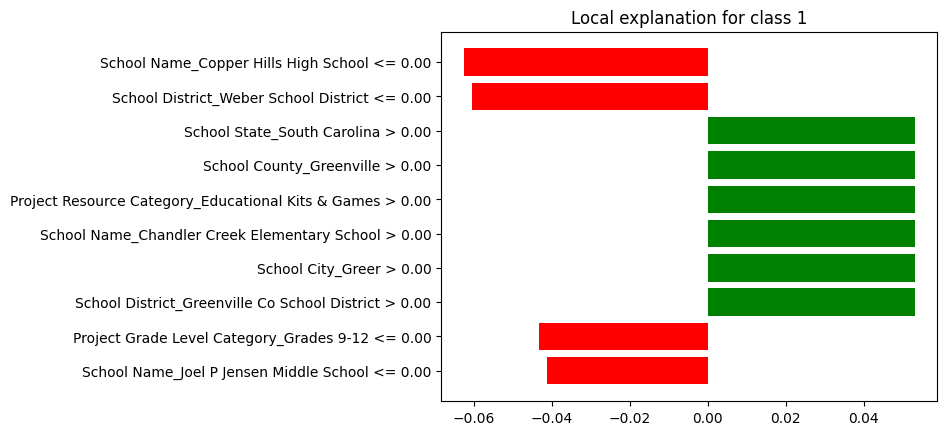

Bottom list


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


exp_list_with_feature_names = [('Project Cost', -0.11679154211094461), ('School Name_Copper Hills High School', -0.0602640070396364), ('Project Grade Level Category_Grades 9-12', -0.057353364709470896), ('School District_Weber School District', -0.047658412437891096), ('Teacher Project Posted Sequence', -0.04239216555244182), ('School Name_Oakcrest Elementary School', -0.032994682631321326), ('School Name_Joel P Jensen Middle School', -0.032832186222824356), ('Project Subject Subcategory Tree_Literature & Writing', -0.03194793233430383), ('Project Resource Category_Books', 0.02655979075639155), ('Project Subject Subcategory Tree_Music', -0.023734603292906206)]
Directory 'C:/Users/User/random_forest/xai_test_results/lime/Fold0/bottom' created successfully
Saving lime exp for 6f9c30c76d518b4f47ee53b90635f6a6_random_forest


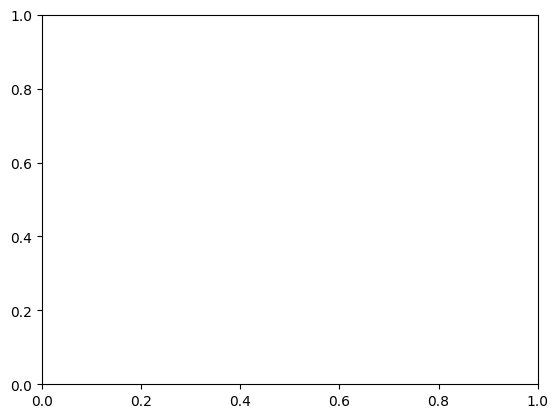

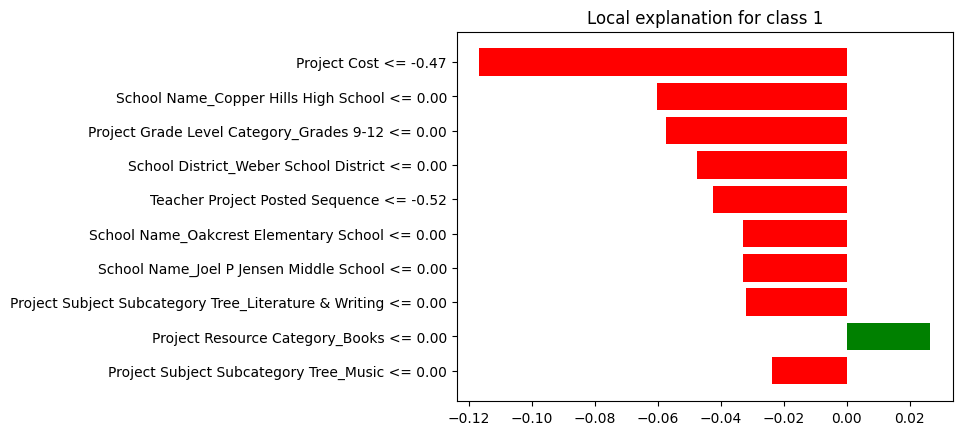

Explanation for Kernel Shap
Kernel Explainer Loading ..... 
Kernel Explainer : Done training
Directory 'C:/Users/User/random_forest/xai_test_results/kernelshap/Fold0/top/' created successfully
Directory 'C:/Users/User/random_forest/xai_test_results/kernelshap/Fold0/bottom/' created successfully
Top list
len(exp[1]) = 12306
exp[1] = [0.02990804 0.07066699 0.03820607 ... 0.         0.         0.        ]
len(feat_names) = 12306
feat_names top entries = ['Project Cost', 'School Percentage Free Lunch', 'Teacher Project Posted Sequence', 'Project Type_Professional Development', 'Project Type_Student-Led', 'Project Type_Teacher-Led', 'Project Subject Category Tree_Applied Learning', 'Project Subject Category Tree_Applied Learning, Health & Sports', 'Project Subject Category Tree_Applied Learning, History & Civics', 'Project Subject Category Tree_Applied Learning, Literacy & Language']
type(exp_as_list) = <class 'list'>
Saving kernelshap exp for C:/Users/User/random_forest/xai_test_results/ke

In [21]:
explanations_pipeline(root, models, train_files, test_files, test_pred, "random_forest")